In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

a good start would be to look at some randomly simulated games, where each player just picks a point on a board

In [7]:
def randgame1(n,p):
    w = 0
    for k in range(p):
        mx = np.zeros((n,n), int)
        choices = np.random.choice(mx.size, int(np.ceil(n*n/2)), replace=False)
        mx.ravel()[choices] = 1

        if np.linalg.det(mx) == 0:
            w = w+1
    return w, w/p

In [8]:
def randgame0(n,p):
    w = 0
    for k in range(p):
        mx = np.zeros((n,n), int)
        choices = np.random.choice(mx.size, int(np.floor(n*n/2)), replace=False)
        mx.ravel()[choices] = 1

        if np.linalg.det(mx) == 0:
            w = w+1
    return w, w/p

In [9]:
print(randgame1(3,10000), 'winning games & ratio of winning games')
print(randgame0(3,10000), 'winning games & ratio of winning games')


(4179, 0.4179) winning games & ratio of winning games
(7172, 0.7172) winning games & ratio of winning games


i want code that just tries every possible combination instead of random matrices, to get an accurate idea of how many winning/losing games there are for each player

In [14]:
def shuffle(n, k): #shuffle the string of 1s and 0s giving every combinatorial combination
    result = []
    for ones in itertools.combinations(range(n), k):
        s = ['0'] * n
        for bit in ones:
            s[bit] = '1'
        result.append(''.join(s))
    return result


In [ ]:
def deterministicmx(n, p0 = True):
    w=0

    #find no 1s that should be in each string, left overs will be 0s

    if p0 == True:
        j = int(np.floor(n*n/2))
    else:
        j = int(np.ceil(n*n/2))

    flatmxs = shuffle(n*n,j)
    
    for i in range(len(flatmxs)): # turn into nxn mx
        mxstr = np.array(list(map(int, flatmxs[i])))
        mx = mxstr.reshape(n,n)

        if np.linalg.det(mx) == 0:
            w = w+1

    return len(flatmxs), w,

In [ ]:
for N in range(1,6):

    a,b= deterministicmx(N)
    a,c= deterministicmx(N, False)

    print(f'Number of possible finished games for N = {N} is {a}: when both players play randomly we get')
    print(f'Player 0 wins {b} times out of {a}, {b*100/a}% when P0 starts')
    print(f'Player 1 wins {a-b} times out of {a}, {(a-b)*100/a}% when P0 starts')
    print(f'Player 0 wins {c} times out of {a}, {(c)*100/a}% when P1 starts')
    print(f'Player 1 wins {a-c} times out of {a}, {(a-c)*100/a}% when P1 starts')

Number of possible finished games for N = 1 is 1: when both players play randomly we get
Player 0 wins 1 times out of 1, 100.0% when P0 starts
Player 1 wins 0 times out of 1, 0.0% when P0 starts
Player 0 wins 0 times out of 1, 0.0% when P1 starts
Player 1 wins 1 times out of 1, 100.0% when P1 starts
Number of possible finished games for N = 2 is 6: when both players play randomly we get
Player 0 wins 4 times out of 6, 66.66666666666667% when P0 starts
Player 1 wins 2 times out of 6, 33.333333333333336% when P0 starts
Player 0 wins 4 times out of 6, 66.66666666666667% when P1 starts
Player 1 wins 2 times out of 6, 33.333333333333336% when P1 starts
Number of possible finished games for N = 3 is 126: when both players play randomly we get
Player 0 wins 90 times out of 126, 71.42857142857143% when P0 starts
Player 1 wins 36 times out of 126, 28.571428571428573% when P0 starts
Player 0 wins 54 times out of 126, 42.857142857142854% when P1 starts
Player 1 wins 72 times out of 126, 57.142857

In [13]:
#.  a,b = deterministicmx(6)
#.  a,c = deterministicmx(6, False)

    #print('Number of possible finished games for N=6', a)
#print('Player 0 wins ', b, 'times out of', a,',', b*100/a ,'% when P0 starts')
#print('Player 1 wins ', a-c, 'times out of', a,',', (a-c)*100/a, '% when P1 starts')

This would take over 80 hours to run on my computers, as 36 Choose 18 is 9075135300, aka the number of different possible games.
here is a reasonable place to stop

we can see that when n is even we get the same results no matter which player starts, this is a bad approximation of a real life game as players will play reactivly not blindly to previous moves.

Although this time could be halved as we know the set of outcome games will be the same no matter who starts, as there is an even number of elements in a 6x6 matrix, thus we would only need to compute determinmx(6), we could also remove combinations which are just rotations or row/column shuffels of other matrices, as these operations dont change the determinant value but this is just a test so we dont really care.

I want to make a function that takes a matrix as imput, and then applys the algorithm i came up with to return an optimal move, inserting 0 somewhere
we can then play against it, or run a random 1s player against it to see if it makes any mistakes

In [14]:

#first we have to do some bookkeeping on the matrix, eg checking that all elements are suitable, and that there are not too many 1s or 0s to ensure its a valid playing position

ALLOWED = {0, 1, "*", "0", "1"}

def _normalise_to_object_array(mat):
    A = np.array(mat, dtype=object, copy=True)

    #ensure that matrix is structured properly

    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("Matrix must be square (n×n).")
    if A.shape[0] < 4:
        raise ValueError("Strategy requires n > 3 (i.e. n >= 4).")

    # ensure that the contents of the matrix is correct and remove any accidental commas
    
    flat = A.ravel()
    for k, x in enumerate(flat):
        if x not in ALLOWED:
            raise ValueError(f"Invalid entry {x!r} at flat index {k}. Allowed: 0, 1, '*', '0', '1'.")
        if x == "0":
            flat[k] = 0
        elif x == "1":
            flat[k] = 1
        elif x == "*":
            flat[k] = "*"
    return A

In [15]:
def p0_move(mat):

    key_rows=(0, 1, 2, 3)

    A = _normalise_to_object_array(mat)
    n = A.shape[0]
    r1, r2, r3, r4 = key_rows
    pairs = [(r1, r2), (r3, r4)]
    key_set = set(key_rows)

    #define some helper functions to be used when making moves

    # Find first (1,*) or (*,1) in either key pair and put 0 in the * partner.
    def mirror_move(board: np.ndarray):
        for a, b in pairs:
            cols = np.where((board[a, :] == 1) & (board[b, :] == "*"))[0]
            if cols.size:
                j = int(cols[0])
                B = board.copy()
                B[b, j] = 0
                return B

            cols = np.where((board[b, :] == 1) & (board[a, :] == "*"))[0]
            if cols.size:
                j = int(cols[0])
                B = board.copy()
                B[a, j] = 0
                return B
        return None
    #if possible, create (0,*) in a completely blank (*,*) column of a key pair. (we now know this doesnt work)
    def seed_move(board: np.ndarray):
        for a, b in pairs:
            cols = np.where((board[a, :] == "*") & (board[b, :] == "*"))[0]
            if cols.size:
                j = int(cols[0])
                B = board.copy()
                B[a, j] = 0
                return B
        return None

    def play_outside(board: np.ndarray):
        outside_rows = [i for i in range(n) if i not in key_set]
        if not outside_rows:
            return None
        sub = board[outside_rows, :]
        where_star = np.argwhere(sub == "*")
        if where_star.size:
            rr, cc = where_star[0]
            i = outside_rows[int(rr)]
            j = int(cc)
            B = board.copy()
            B[i, j] = 0
            return B
        return None

    def play_anywhere(board: np.ndarray):
        where_star = np.argwhere(board == "*")
        if where_star.size == 0:
            return None
        i, j = where_star[0]
        B = board.copy()
        B[int(i), int(j)] = 0
        return B

    #this is now the ordering for making moves
    out = mirror_move(A)
    if out is not None:
        return out

    out = seed_move(A)
    if out is not None:
        return out

    out = play_outside(A)
    if out is not None:
        return out

    out = play_anywhere(A)
    if out is not None:
        return out



In [16]:
#this is its opponent, which will make random moves. theoretically it should always loose, but for enough repetes should simulate someone new to the game playing with no real strategy.
#if p0 algo has any pitfalls this should find it with enough iterations

def randP1(mat, rng=None):
    if rng is None:
        rng = np.random.default_rng() #had issues with setitng specific random seeds, this fixed it

    A = np.array(mat, dtype=object, copy=True)

    stars = np.argwhere(A == "*") #find all *s eg list of possible moves
    if stars.size == 0:
        raise ValueError("No available '*' cells.")

    i, j = stars[rng.integers(0, stars.shape[0])] #pick a * at random and converet it to a 1
    B = A.copy()
    B[int(i), int(j)] = 1
    return B

we can now try simulating full games with our stragety for p0

In [17]:
def p1start(n):
    #produce an 'empty playing table' eg an n*n mx full of *'s
    M = np.full((n, n), "*", dtype=object)

    #play n*n moves to populate entire matrix from empty

    for i in range(n*n):
        if i % 2 == 0:
            M = randP1(M)
        if i % 2 == 1:
            M = p0_move(M)

    M = np.vectorize(lambda x: 0 if x == "0" else 1 if x == "1" else x)(M).astype(float)
        
    return M, np.linalg.det(M)

def p0start(n):
    M = np.full((n, n), "*", dtype=object)

    #play n*n moves to populate entire matrix from empty

    for i in range(n*n):
        if i % 2 == 1:
            M = randP1(M)
        if i % 2 == 0:
            M = p0_move(M)

    M = np.vectorize(lambda x: 0 if x == "0" else 1 if x == "1" else x)(M).astype(float)

    return M, np.linalg.det(M)



print(p1start(4))
print(p0start(4))


(array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.]]), 0.0)
(array([[0., 1., 1., 0.],
       [1., 0., 0., 1.],
       [0., 1., 0., 1.],
       [1., 0., 1., 0.]]), 0.0)


Now we know that a single iteratoin of the game works, lets try simulating it for a few thousand, to see if we find any slip ups from our algorithm

In [18]:
def gamesim(n,k): #simulate a game of size n*n 2 k times, k times per each player starting
    v = 0
    for i in range(k):
        a,b = p1start(n)
        if b != 0:
            print(a,b, 'p1start') #diagnostic code
            v += 1
    for i in range(k):
        a,b = p0start(n)
        if b != 0:
            print(a,b, 'p0start')
            v += 1
    return v
    
print(gamesim(4,100))
print(gamesim(5,100))
print(gamesim(6,100)) #ive reduced the values of k as i know this doesnt work, to allow notebook to run faster

0
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0.]] 1.0 p1start
[[1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 1. 1. 0. 1.]
 [1. 0. 0. 1. 0.]
 [1. 1. 0. 1. 1.]] -1.0 p1start
[[0. 0. 0. 0. 1.]
 [1. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 1.]] 1.0 p1start
[[0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1.]
 [1. 1. 0. 1. 1.]] -1.0 p1start
[[0. 0. 0. 0. 1.]
 [0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [1. 1. 0. 0. 0.]
 [1. 1. 0. 1. 1.]] 1.0 p1start
[[1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0.]
 [1. 1. 1. 0. 1.]] -1.0 p1start
[[0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1.]
 [1. 0. 1. 1. 1.]] -1.0 p1start
[[1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0.]
 [1. 1. 0. 1. 1.]] 1.0 p1start
[[0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1.]] -1.0 p1start
[[0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 1. 0

it seems that our method only works for n = 4, but in theory it should work for all n, there may be an issue with my code

looking into it i see that we seem to place a 0 inside the key rows earlier then we have to, this can be taken advantage of by p1.
this makes sense as for the case n=4 all rows are key rows, thus this issue would never occur


we also run into some new floating point issues with finding the determinant of larger values of n. this can be fixed by finding the rank instead, as that will indicate the exact same thing, if less that n then det = 0
we have fixed this in the new function

In [19]:
def p0_move(mat, key_rows=(0,1,2,3)):

    A = _normalise_to_object_array(mat) #ensure matrix is suitable
    n = A.shape[0]
    r1, r2, r3, r4 = key_rows
    pairs = [(r1, r2), (r3, r4)]
    key_set = set(key_rows)

    #first lets define some helper functions for each of the moves we may want to make

    # Outside rows and whether outside is full
    outside_rows = [i for i in range(n) if i not in key_set]
    outside_full = True
    if outside_rows:
        outside_full = (np.count_nonzero(A[outside_rows, :] == "*") == 0)

    # Count columns in key pairs that look like (0,*) or (*,0)
    def open_pairs_count(board: np.ndarray):
        cnt = 0
        for a, b in pairs:
            cnt += int(np.count_nonzero((board[a, :] == 0) & (board[b, :] == "*")))
            cnt += int(np.count_nonzero((board[a, :] == "*") & (board[b, :] == 0)))
        return cnt
    
    # If a key pair has (1,*) or (*,1), insert a 0
    def mirror_move(board: np.ndarray):
        for a, b in pairs:
            cols = np.where((board[a, :] == 1) & (board[b, :] == "*"))[0]
            if cols.size:
                j = int(cols[0])
                B = board.copy()
                B[b, j] = 0
                return B

            cols = np.where((board[b, :] == 1) & (board[a, :] == "*"))[0]
            if cols.size:
                j = int(cols[0])
                B = board.copy()
                B[a, j] = 0
                return B
        return None

    #this is to let us play outside the key rows, eg if there isnt an ideal move to be made there.
    def play_outside(board: np.ndarray):
        if not outside_rows:
            return None
        sub = board[outside_rows, :]
        where_star = np.argwhere(sub == "*")
        if where_star.size:
            rr, cc = where_star[0]
            i = outside_rows[int(rr)]
            j = int(cc)
            B = board.copy()
            B[i, j] = 0
            return B
        return None
    
    # Choose a blank complementary pair (*,*) and place 0 in one cell to make (0,*).
    def create_open_pair(board: np.ndarray):
        for a, b in pairs:
            cols = np.where((board[a, :] == "*") & (board[b, :] == "*"))[0]
            if cols.size:
                j = int(cols[0])
                B = board.copy()
                B[a, j] = 0
                return B
        return None

    #now we make our actual moves!

    # Always do forced mirroring first - best case move
    out = mirror_move(A)
    if out is not None:
        return out

    #If outside is not full, and there is nowhere to mirror, then place in outside
    if not outside_full:
        out = play_outside(A)
        if out is not None:
            return out

    #in case something goes wrong, just insert a 0 wherever you can, this should never happen ideally except for a final move.
    op = open_pairs_count(A)
    if op == 0:
        out = create_open_pair(A)
        if out is None:
            # No (*,*) pairs left. Only possibility is matrix full, but we checked it isn't.
            i, j = np.argwhere(A == "*")[0]
            B = A.copy()
            B[int(i), int(j)] = 0
            return B
        return out


In [20]:
#lets try again with out new algorithm for p0

def gamesim(n,k): #simulate a game of size n*n 2 k times, k times per each player starting
    v = 0
    for i in range(k):
        a,b = p1start(n)
        if np.linalg.matrix_rank(a) == n:
            v += 1
    for i in range(k):
        a,b = p0start(n)
        if np.linalg.matrix_rank(a) == n:
            v += 1
    return v
    
print(gamesim(4,1000))
print(gamesim(5,1000))
print(gamesim(6,1000))

0
0
0


voila, our new algorithm works for n op to 6, lets try some larger values

In [21]:
for i in range(9):
        print(f'n = {i+7}, lost games: {gamesim(i+7,1000)} of 2000.')

n = 7, lost games: 0 of 2000.
n = 8, lost games: 0 of 2000.
n = 9, lost games: 0 of 2000.
n = 10, lost games: 0 of 2000.
n = 11, lost games: 0 of 2000.
n = 12, lost games: 0 of 2000.
n = 13, lost games: 0 of 2000.
n = 14, lost games: 0 of 2000.
n = 15, lost games: 0 of 2000.


Excellent. our agorithm works, both for when p0 starts and for when p1 starts.


In [ ]:
def plot_rank_pie(n, p0=True, show_counts=True, ax=None):

    #ensure colours for ranks are the same across graphs
    cmap = plt.get_cmap("tab10")
    rank_colours = {r: cmap(r) for r in range(6)}

    #construct the matrices like we did in deterministicMX
    j = (n*n // 2) if p0 else ((n*n + 1) // 2)
    flatmxs = shuffle(n * n, j)
    rank_counts = np.zeros(n + 1, dtype=int) # we will populate this with all the ranks of the matrices

    for s in flatmxs: #find rank of matrix
        flat = np.fromiter((int(ch) for ch in s), dtype=float, count=n*n)
        A = flat.reshape(n, n)

        sv = np.linalg.svd(A, compute_uv=False)
        sv = np.round(sv, decimals=10)

        eps = np.finfo(float).eps
        tol_eff = max(A.shape) * eps * sv.max()

        r = int(np.sum(sv > tol_eff))
        rank_counts[r] += 1

    total = len(flatmxs)


    ranks = [r for r in range(n + 1) if rank_counts[r] > 0]
    sizes = [int(rank_counts[r]) for r in ranks]
    labels = [f"rank {r}" + (f"\n({rank_counts[r]})" if show_counts else "") for r in ranks]
    colours = [rank_colours[r] for r in ranks]  # uniform across all plots

    if ax is None: #for single graphs
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        standalone = True
    else:
        standalone = False

    ax.pie(sizes, labels=labels, colors=colours, autopct=lambda pct: f"{pct:.1f}%")
    ax.set_title(f"n={n}, p0={p0}\nones={j}, No. matrices={total}")

    if standalone:
        plt.tight_layout()
        plt.show()

    return rank_counts, total

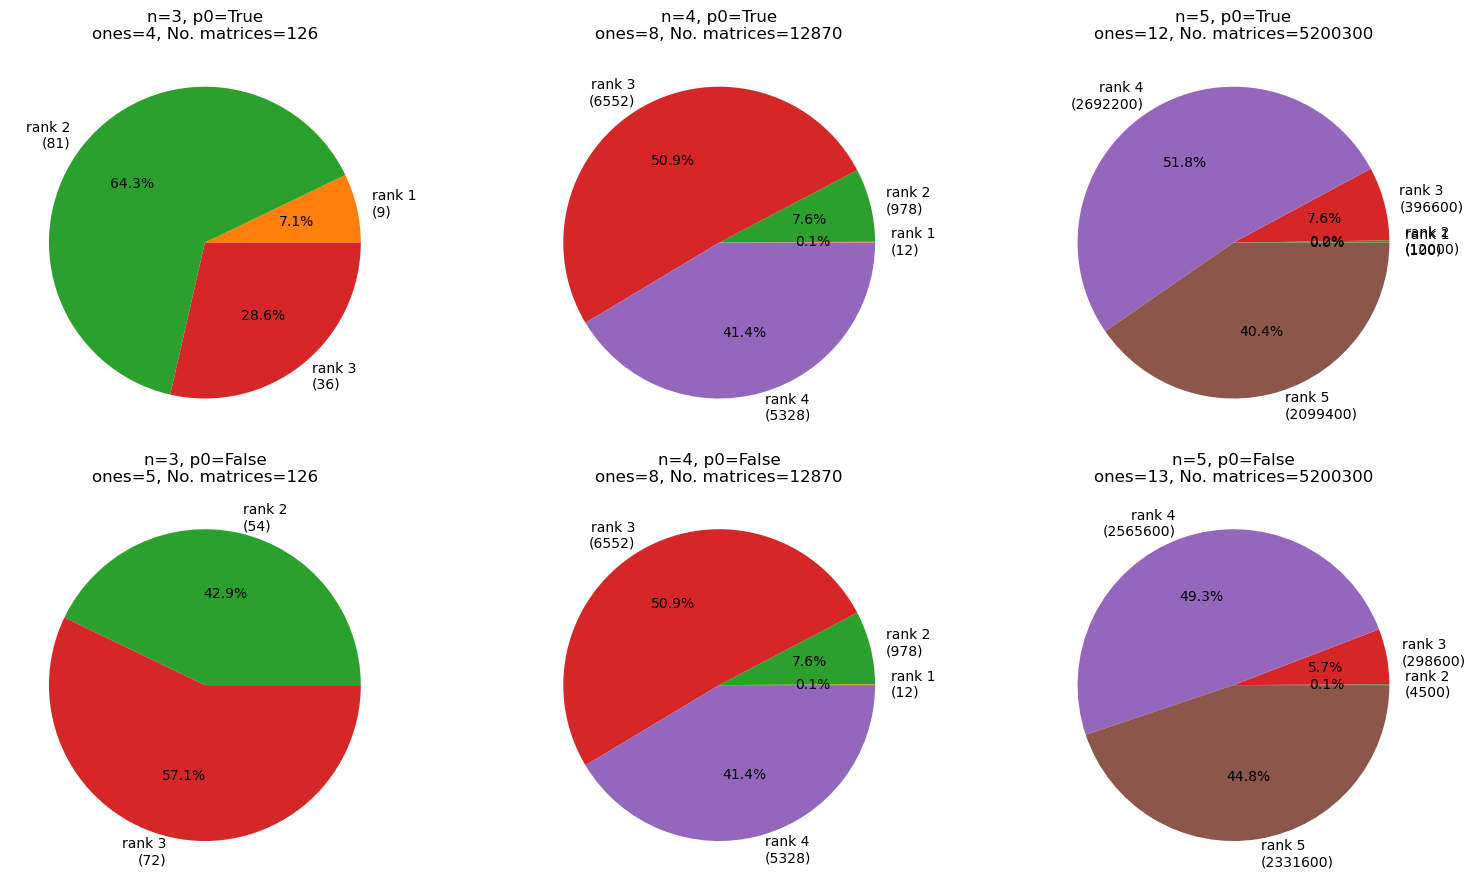

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

plot_rank_pie(3, True,  ax=axes[0, 0])
plot_rank_pie(3, False, ax=axes[1, 0])

plot_rank_pie(4, True,  ax=axes[0, 1])
plot_rank_pie(4, False, ax=axes[1, 1])

plot_rank_pie(5, True,  ax=axes[0, 2])
plot_rank_pie(5, False, ax=axes[1, 2])

plt.tight_layout()
plt.show()